In [105]:
import numpy as np 
import matplotlib.pyplot as plt
import cvxpy as cvx
from scipy.linalg import circulant
from scipy.stats import norm

def BinaryRandomMatrix(S,M,p):
    r = np.random.rand(S,M)
    m = np.zeros((S,M))
    m[r<p] = 1.0
    return m

def MakeAffinities(params):
    pix = BinaryRandomMatrix(params['Num_tcell'],params['Num_sites'],params['pval_cell']) 
    palphax = (params['c'] + np.random.normal(0,params['sigma_cp'],(params['Num_treg'],params['Num_sites']) ) )* BinaryRandomMatrix(params['Num_treg'],params['Num_sites'],params['pval_treg']) 
    return pix, palphax

def MakeOverlaps(pix,palphax,vx):
    phi_reg_reg = (palphax*vx).dot(palphax.T)
    phi_cell_reg = (pix*vx).dot(palphax.T)
    rvals = pix.dot(vx)
    return phi_reg_reg, phi_cell_reg, rvals

def TrainNetwork(phi_reg_reg,phi_cell_reg,rvals):
    Num_treg = len(phi_reg_reg)
    Num_tcell = len(phi_cell_reg)
    Treg = cvx.Variable(Num_treg)
    G = np.vstack((-(phi_cell_reg.T/rvals).T,-np.eye(Num_treg)))
    h = np.hstack((-np.ones(Num_tcell),np.zeros(Num_treg)))
    constraints = [G@Treg <= h]
    obj = cvx.Minimize((1/2)*cvx.quad_form(Treg,phi_reg_reg))
    prob = cvx.Problem(obj, constraints)
    prob.solve(solver=cvx.ECOS,abstol=1e-9,feastol=1e-7,abstol_inacc=1e-5,feastol_inacc=1e-5,max_iters=5000,verbose=False)
    Tcell=constraints[0].dual_value[:Num_tcell]
    Treg=Treg.value
    return Tcell,Treg

We start with Owen's code (cleaned up a bit), which samples binding probabilities independently for each cell-antigen pair:

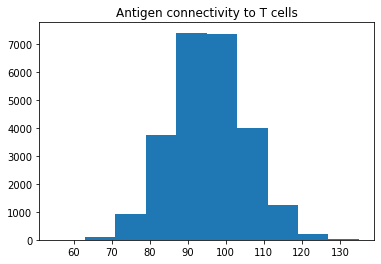

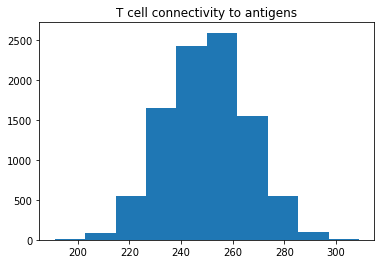

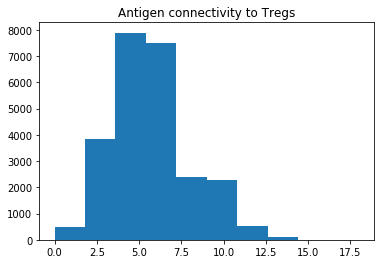

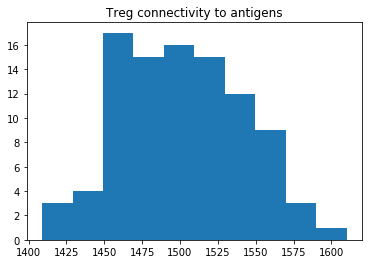

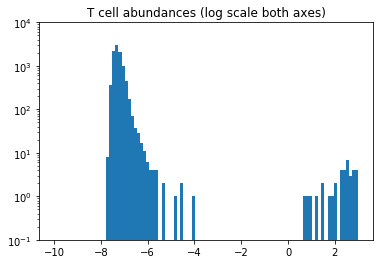

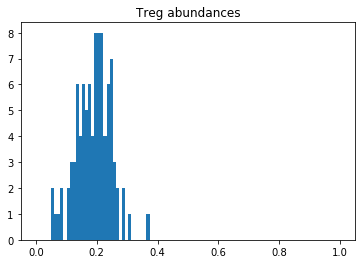

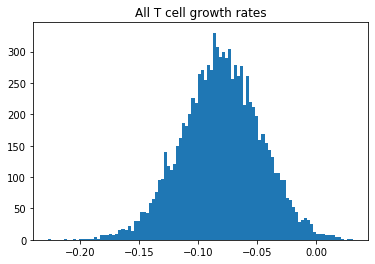

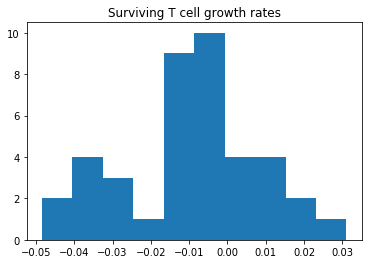

In [103]:
#declare simulation paramaters:
params={
#the number of Tregs
'Num_treg' : 95,
#the number of Tcells
'Num_tcell' : 9500,
#the number of sites
'Num_sites' : 25000,
#the Treg- antigen site binding strenth
'c' : 1.0,
#the varience in Treg-antigen binding around zero
'sigma_c' : 0.0,
#the varience in Treg-antigen binding around c
'sigma_cp' : 0.0,
#the binding
'pval_cell' : 0.01,
'pval_treg' : 0.06,
'max_v' : 1.0}

#Define antigen concentrations
vx = 0.5*params['max_v'] * np.ones(params['Num_sites']) #+ np.random.uniform(-max_v/2,max_v/2,Num_sites) 

#generate a Treg-Tcell graph
#######################################
pix, palphax = MakeAffinities(params)

#now compute the r_{i} and \phi quantities
######################################################################
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)

####################################################################################
#compute the Treg steady state and active set of constraints
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)

#Make lots of histograms
plt.hist( pix.sum( axis = 0) )
plt.gca().set_title('Antigen connectivity to T cells')
plt.show()
plt.hist( pix.sum( axis = 1) )
plt.gca().set_title('T cell connectivity to antigens')
plt.show()
plt.hist( palphax.sum( axis = 0) )
plt.gca().set_title('Antigen connectivity to Tregs')
plt.show()
plt.hist( palphax.sum( axis = 1) )
plt.gca().set_title('Treg connectivity to antigens')
plt.show()
plt.hist(np.log10(Tcell),bins=np.linspace(-10,3,100))
plt.gca().set_title('T cell abundances (log scale both axes)')
plt.gca().set_yscale('log')
plt.gca().set_ylim((0.1,10000))
plt.show()
plt.hist(Treg,bins=np.linspace(0,1,100))
plt.gca().set_title('Treg abundances')
plt.show()

#Randomly vary all the v_x values between 0 and max_v:
thresh = 1e-3
#vx = params['max_v']+np.random.randn(params['Num_sites'])*0.1
vx = params['max_v']*np.random.rand(len(vx))
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
out = (phi_cell_reg.T/rvals).T.dot(Treg)
plt.hist(1-out,bins=100)
plt.gca().set_title('All T cell growth rates')
plt.show()
out = out[Tcell>thresh]
plt.hist(1-out)
plt.gca().set_title('Surviving T cell growth rates')
plt.show()

This scheme fails to find the "$\rho$ point", because too many antigens fall in the Treg niche overlap. Let's try a different way of sampling the affinities. First, we'll choose the number of Tregs connected to each antigen from a narrow distribution, but leave everything else random:

In [65]:
def MakeAffinities_fixed_degree(params):
    pix = BinaryRandomMatrix(params['Num_tcell'],params['Num_sites'],params['pval_cell']) 
    palphax = np.zeros((params['Num_treg'],params['Num_sites']))
    degree = np.asarray(params['degree']+np.random.randn(params['Num_sites'])*params['sigma_degree'],dtype=int)
    for i in range(params['Num_sites']):
        palphax[:degree[i],i] = params['c']*np.ones(degree[i])+np.random.randn(degree[i])*params['sigma_c']
        np.random.shuffle(palphax[:,i])
    return pix, palphax

If we give all the antigens exactly the same connectivity to Tregs, and make all the binding affinities exactly the same, we get our desired result: all the T cells coexist, and the growth rates are totally insensitive to $v_x$. But if we add even a tiny amount of noise to either, competitive exclusion gets enforced, and we get some sensitivity to the $v_x$. It is small, though -- one percent noise in the degree and in the binding strength gives a proliferation rate of about a tenth of a percent of the basal rate.

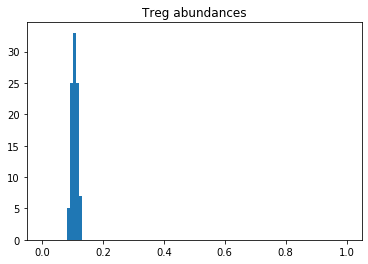

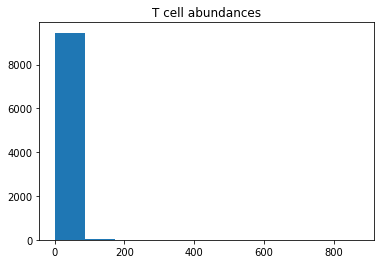

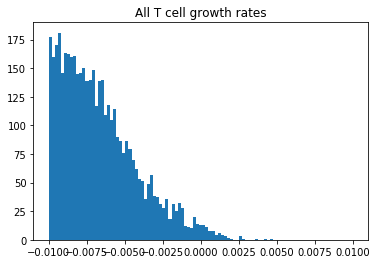

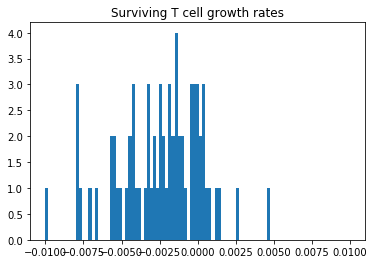

In [104]:
params['degree'] = 10
params['sigma_degree'] = 0.1
params['sigma_c'] = 0.01
pix, palphax = MakeAffinities_fixed_degree(params)
vx=(params['max_v']/2)*np.ones(params['Num_sites'])

#Make overlaps and train
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)
plt.hist(Treg,bins=np.linspace(0,1,100))
plt.gca().set_title('Treg abundances')
plt.show()
plt.hist(Tcell)
plt.gca().set_title('T cell abundances')
plt.show()

#Randomly vary all the v_x values between 0 and max_v:
thresh = 1e-3
#vx = params['max_v']+np.random.randn(params['Num_sites'])*0.1
vx = params['max_v']*np.random.rand(len(vx))
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
out = (phi_cell_reg.T/rvals).T.dot(Treg)
plt.hist(1-out, bins=np.linspace(-.01,.01,100))
plt.gca().set_title('All T cell growth rates')
plt.show()

out = out[Tcell>thresh]
plt.hist(1-out, bins=np.linspace(-.01,.01,100))
plt.gca().set_title('Surviving T cell growth rates')
plt.show()

We can also try using an evenly tiled circulant matrix. This works extremely well:

In [119]:
def MakeAffinities_circulant(params):
    circ = circulant(norm.pdf(np.linspace(-params['Num_sites']/2,params['Num_sites']/2,params['Num_sites'])/params['niche_width']))
    pix = circ[np.linspace(0,params['Num_sites']-1,params['Num_tcell'],dtype=int),:]
    palphax = params['c']*circ[np.linspace(0,params['Num_sites']-1,params['Num_treg'],dtype=int),:]
    return pix, palphax

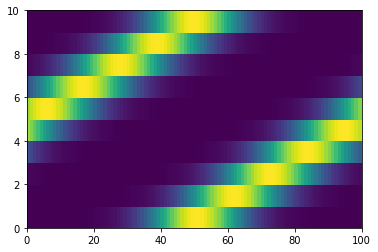

In [122]:
params_test = {}
params_test['niche_width'] = 10
params_test['Num_sites'] = 100
params_test['Num_tcell'] = 10
params_test['Num_treg'] = 10
params_test['c'] = 1
plt.pcolor(MakeAffinities_circulant(params_test)[0])
plt.show()

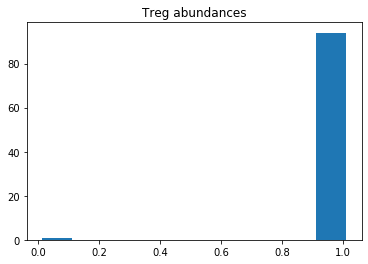

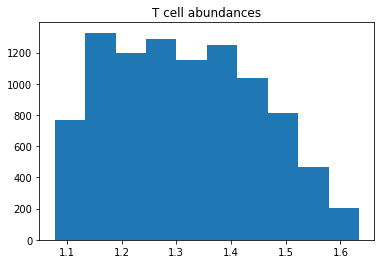

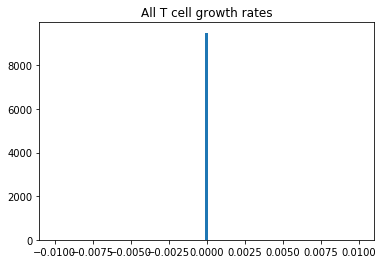

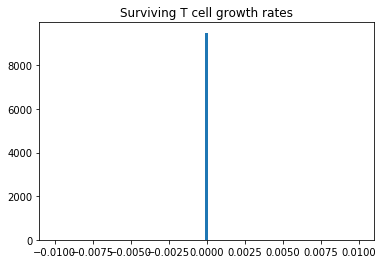

In [127]:
params['niche_width'] = params['Num_sites']/params['Num_treg']
pix, palphax = MakeAffinities_circulant(params)
vx = (params['max_v']/2)*np.ones(params['Num_sites'])

#Make overlaps and train
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)
plt.hist(Treg)
plt.gca().set_title('Treg abundances')
plt.show()
plt.hist(Tcell)
plt.gca().set_title('T cell abundances')
plt.show()

#Randomly vary all the v_x values between 0 and max_v:
thresh = 1e-3
#vx = params['max_v']+np.random.randn(params['Num_sites'])*0.1
vx = params['max_v']*np.random.rand(len(vx))
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
out = (phi_cell_reg.T/rvals).T.dot(Treg)
plt.hist(1-out, bins=np.linspace(-.01,.01,100))
plt.gca().set_title('All T cell growth rates')
plt.show()

out = out[Tcell>thresh]
plt.hist(1-out, bins=np.linspace(-.01,.01,100))
plt.gca().set_title('Surviving T cell growth rates')
plt.show()

Or a random subsample of circulant matrix. In this case, a lot of Tregs go extinct, so we need to start with more. We get an extremely strange result, though, which is the combination of a lot of variability in Treg population size, but no sensitivity to $v_x$!

In [128]:
def MakeAffinities_circulant_rand(params):
    circ = circulant(norm.pdf(np.linspace(-params['Num_sites']/2,params['Num_sites']/2,params['Num_sites'])/params['niche_width']))
    Tcell_choice = np.random.choice(params['Num_sites'],size=params['Num_tcell'],replace=True)
    Treg_choice = np.random.choice(params['Num_sites'],size=params['Num_treg'],replace=True)
    pix = circ[Tcell_choice,:]
    palphax = params['c']*circ[Treg_choice,:]
    return pix, palphax

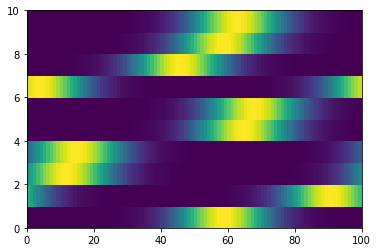

In [132]:
params_test = {}
params_test['niche_width'] = 10
params_test['Num_sites'] = 100
params_test['Num_tcell'] = 10
params_test['Num_treg'] = 10
params_test['c'] = 1
plt.pcolor(MakeAffinities_circulant_rand(params_test)[0])
plt.show()

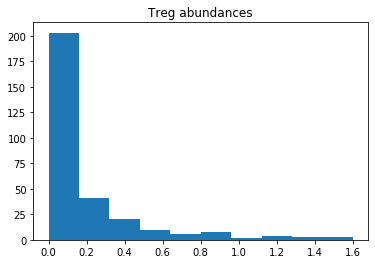

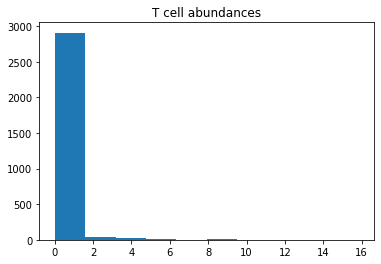

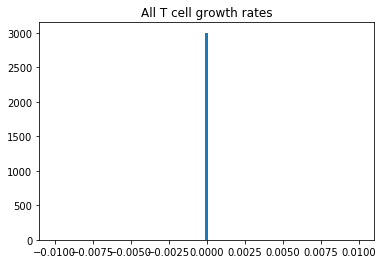

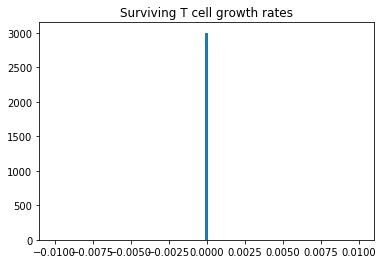

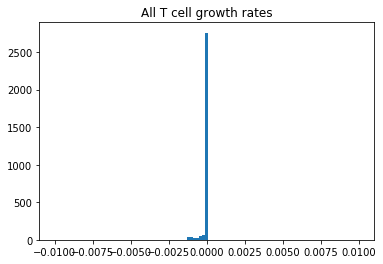

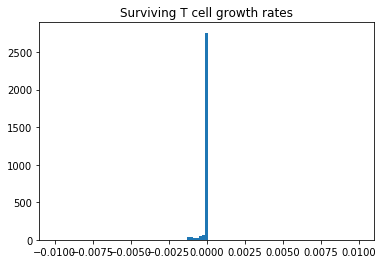

In [143]:
Num_path = 100
params['Num_treg'] = 300
params['Num_tcell'] = 3000
params['Num_sites'] = 3000
params['niche_width'] = 5*params['Num_sites']/params['Num_treg']
pix, palphax = MakeAffinities_circulant_rand(params)
vx = (params['max_v']/2)*np.ones(params['Num_sites'])
vx[:Num_path] = 0

#Make overlaps and train
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
Tcell, Treg = TrainNetwork(phi_reg_reg,phi_cell_reg,rvals)
plt.hist(Treg)
plt.gca().set_title('Treg abundances')
plt.show()
plt.hist(Tcell)
plt.gca().set_title('T cell abundances')
plt.show()

#Randomly vary all the v_x values between 0 and max_v, keeping pathogens at 0:
thresh = 1e-3
#vx = params['max_v']+np.random.randn(params['Num_sites'])*0.1
vx = params['max_v']*np.random.rand(params['Num_sites'])
vx[:Num_path] = 0
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
out = (phi_cell_reg.T/rvals).T.dot(Treg)
plt.hist(1-out, bins=np.linspace(-.01,.01,100))
plt.gca().set_title('All T cell growth rates')
plt.show()

out = out[Tcell>thresh]
plt.hist(1-out, bins=np.linspace(-.01,.01,100))
plt.gca().set_title('Surviving T cell growth rates')
plt.show()

#Randomly vary all the v_x values between 0 and max_v, including pathogens:
thresh = 1e-3
#vx = params['max_v']+np.random.randn(params['Num_sites'])*0.1
vx = params['max_v']*np.random.rand(params['Num_sites'])
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
out = (phi_cell_reg.T/rvals).T.dot(Treg)
plt.hist(1-out, bins=np.linspace(-.01,.01,100))
plt.gca().set_title('All T cell growth rates')
plt.show()

out = out[Tcell>thresh]
plt.hist(1-out, bins=np.linspace(-.01,.01,100))
plt.gca().set_title('Surviving T cell growth rates')
plt.show()

The last two plots above include the addition of 100 pathogen antigens that are statistically identical to self antigens. We can also go to the other extreme, and add pathogen antigens that are guaranteed _a priori_ not to bind to any Tregs. I will sample the T cell binding affinities randomly from the original matrix:

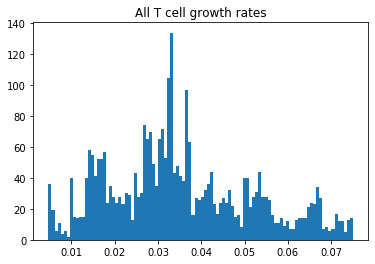

In [144]:
vx = params['max_v']*np.random.rand(params['Num_sites']+Num_path)
vx[:Num_path] = 0 #Get rid of statistically identical pathogens from previous part
pix_new = pix[:,np.random.choice(np.arange(Num_path,params['Num_sites']),size=Num_path,replace=True)]
palphax_new = np.zeros((len(palphax),Num_path))
pix = np.hstack((pix,pix_new))
palphax = np.hstack((palphax,palphax_new))
phi_reg_reg, phi_cell_reg, rvals = MakeOverlaps(pix,palphax,vx)
out = (phi_cell_reg.T/rvals).T.dot(Treg)
plt.hist(1-out,bins=100)
plt.gca().set_title('All T cell growth rates')
plt.show()